In [1]:
import os
import pandas as pd
import nibabel as nib
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from skimage.measure import block_reduce
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorly as tl

#Debugging import
import importlib
var = 'TensorDecisionTreeRegressorP' #the published version of code
package = importlib.import_module(var)
for name, value in package.__dict__.items():
    if not name.startswith("__"):
        globals()[name] = value

from TensorDecisionTreeRegressorP import *

import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.model_selection import train_test_split


# File path to the CSV file
csv_file = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
df = pd.read_csv(csv_file)

# Remove rows where ADAS11_bl is missing (NaN)
df_cleaned = df.dropna(subset=['RAVLT_forgetting'])

# Extract the 'ADAS11_bl' column as the y variable
y_variable = df_cleaned['RAVLT_forgetting'].values

# Split the dataframe based on the DX_bl column values
cn_group = df_cleaned[df_cleaned['DX_bl'] == 'CN']
ad_group = df_cleaned[df_cleaned['DX_bl'] == 'AD']
lmci_group = df_cleaned[df_cleaned['DX_bl'] == 'LMCI']

# Display the counts for each group after removing NA
print(f"CN group size: {cn_group.shape[0]}")
print(f"AD group size: {ad_group.shape[0]}")
print(f"LMCI group size: {lmci_group.shape[0]}")

# Directory containing the 3D images
directory = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'

# Initialize dictionaries to hold the images and y values for each group
cn_images, ad_images, lmci_images = [], [], []
cn_y, ad_y, lmci_y = [], [], []

# Function to load the images based on PTID matching and append y values
def load_images_and_y(group, image_list, y_list):
    for _, row in group.iterrows():
        ptid = row['PTID']
        # Find the corresponding file based on PTID
        filename = f'{ptid}.nii.gz'
        file_path = os.path.join(directory, filename)
        
        if os.path.exists(file_path):
            # Load the NIfTI file
            img = nib.load(file_path)
            data = img.get_fdata()
            
            # Append the 3D image data and y value to the respective lists
            image_list.append(data)
            y_list.append(row['RAVLT_forgetting'])
        else:
            print(f"File {filename} not found.")

# Load images and y values for each group
load_images_and_y(cn_group, cn_images, cn_y)
load_images_and_y(ad_group, ad_images, ad_y)
load_images_and_y(lmci_group, lmci_images, lmci_y)

# Convert lists of 3D images and y values to NumPy arrays
if cn_images:
    cn_tensor = np.stack(cn_images, axis=0)
    cn_y = np.array(cn_y)
    print(f"CN 4D tensor shape: {cn_tensor.shape}")
    print(f"CN y shape: {cn_y.shape}")
else:
    print("No CN images loaded.")

if ad_images:
    ad_tensor = np.stack(ad_images, axis=0)
    ad_y = np.array(ad_y)
    print(f"AD 4D tensor shape: {ad_tensor.shape}")
    print(f"AD y shape: {ad_y.shape}")
else:
    print("No AD images loaded.")

if lmci_images:
    lmci_tensor = np.stack(lmci_images, axis=0)
    lmci_y = np.array(lmci_y)
    print(f"LMCI 4D tensor shape: {lmci_tensor.shape}")
    print(f"LMCI y shape: {lmci_y.shape}")
else:
    print("No LMCI images loaded.")



CN group size: 227
AD group size: 186
LMCI group size: 401
CN 4D tensor shape: (227, 48, 48, 48)
CN y shape: (227,)
AD 4D tensor shape: (186, 48, 48, 48)
AD y shape: (186,)
LMCI 4D tensor shape: (401, 48, 48, 48)
LMCI y shape: (401,)


In [68]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.linalg import cholesky, inv
import math
import time
from functools import reduce
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.special import gammaln, logsumexp
from sklearn.linear_model import LassoCV
import itertools
from scipy.linalg import cho_factor, cho_solve
from scipy.stats import geninvgauss

def getouter_list(bet):
    d = len(bet)
    if d == 1:
        return bet[0]
    elif d == 2:
        return np.outer(bet[0], bet[1]).reshape(bet[0].shape + bet[1].shape)
    else:
        return np.outer(getouter_list(bet[:-1]), bet[-1]).reshape(getouter_list(bet[:-1]).shape + bet[-1].shape)

def getmean(X, beta, rank, rank_exclude=None):
    if rank_exclude is None:
        rank_exclude = []

    idx = [i for i in range(rank) if i not in rank_exclude]
    B_list = [getouter_list([beta_elem[r, :] for beta_elem in beta]) for r in idx]
    B = reduce(lambda x, y: x + y, B_list)
    def compute_sum(xx, bb):
        return np.sum(xx * bb)
    mu_B = np.array([compute_sum(xx, B) for xx in X])
    return mu_B

def logsum(lx):
    max_lx = np.max(lx)
    return max_lx + np.log(np.sum(np.exp(lx - max_lx)))

def TP_rankR(X_allr):
    R = X_allr[0].shape[1] if len(X_allr[0].shape) > 1 else None
    if R is None:
        return getouter_list(X_allr)
    else:
        dims = [x.shape[0] for x in X_allr]
        Y = np.zeros(dims)
        for r in range(R):
            outer_results = [x[:, r] for x in X_allr]
            Y += getouter_list(outer_results)
        return Y

def getBeta_mcmc(beta_store):
    nsweep = len(beta_store)
    d = len(beta_store[0])
    rank = beta_store[0][0].shape[0]
    p = [beta_store[0][x].shape[1] for x in range(d)]
    Beta_mcmc = np.zeros((nsweep, np.prod(p)))
    
    for i in range(nsweep):
        coef = np.zeros(np.prod(p))
        for r in range(rank):
            outer_list = [beta_store[i][x][r, :] for x in range(d)]
            coef += getouter_list(outer_list).flatten()
        Beta_mcmc[i, :] = coef    
    return Beta_mcmc

####main function####
def tensor_reg(z_train, x_train, y_train, a_lam, b_lam, phi_alpha, nsweep=1e3, rank=5, burn=0.30,
               nskip=3, scale=True, plot=False):
    
    
    n = len(y_train)
    p = x_train.shape[1:]
    d = len(x_train.shape)-1
    pgamma = z_train.shape[1]
    

    #### standarize ####
    my = np.mean(y_train)
    sy = np.std(y_train, ddof=1) if scale else 1
    if scale:
        obs = (y_train - my) / sy
    else:
        obs = y_train
    if scale:
        mz = np.mean(z_train, axis=0)
        sz = np.array([np.max(z_train[:, i]) - np.min(z_train[:, i]) for i in range(pgamma)])
        sz[sz==0] = 1
        Zt = np.zeros_like(z_train, dtype=float)
        for jj in range(pgamma):
            Zt[:,jj] = (z_train[:,jj] - mz[jj]) / sz[jj] 
    
        Xt = np.zeros_like(x_train, dtype=float)
        mx = np.mean(x_train, axis=0)
        def range_diff(z):
            return np.nanmax(z) - np.nanmin(z)
        sx = np.apply_along_axis(range_diff, axis=0, arr=x_train)
        sx[sx == 0] <- 1
   
        if d == 2:
            for jj in range(n):
                Xt[jj,:,:] = (x_train[jj,:,:] - mx) / sx
        elif d == 3:
            for jj in range(n):
                Xt[jj,:,:,:] = (x_train[jj,:,:,:] - mx) / sx
 
    else:
        Zt = z_train
        Xt = x_train








    

    x_train_nona = Xt
    #### MCMC setup ####
    ZZ = np.dot(Zt.T, Zt)
    vecXt = Xt.reshape(n, np.prod(p))
    vecXt = np.hstack((z_train, vecXt))


    las = LassoCV(cv=5).fit(vecXt, y_train)
    beta_init = las.coef_
    gam = beta_init[0:pgamma]

    ##hyper-par initialize
    a_lam = None; b_lam = None; phi_alpha = None
    if a_lam is None:
        a_lam = [3.0] * rank
        a_lam = np.array(a_lam)
    if b_lam is None:
        b_lam = a_lam**(1/(2*d))
    if phi_alpha is None:
        phi_alpha = np.array([1/rank]*rank)
    phi_a0 = np.sum(phi_alpha)
    a_vphi = phi_a0
    b_vphi = phi_alpha[1] * rank**(1/d)
    c0 = 0
    s0 = 1; a_t = 2_5/2; b_t = 2.5/2 * s0**2

    ##fix randomness for now
    tau2  = 1 / np.random.gamma(size = 1, shape = a_t, scale=1/b_t)
    #tau2 = 2
    phi = np.random.dirichlet(phi_alpha, size = 1)
    varphi = np.random.gamma(size = 1, shape = a_vphi, scale=1/b_vphi)
    #varphi = 0.5
    tau_r = phi * varphi
    # Define the flatten function
    def flatten(nested_list):
        return [item for sublist in nested_list for item in sublist]
    tau_r = flatten(tau_r)
    
    lambda_ = np.array([1.5]*rank*d).reshape((rank, d))
    omega = [None]*d
    for x in range(d):
        omega[x] = np.random.exponential(scale=.5*(a_lam[1]/b_lam[1]), size=(rank,p[x]))

    beta = [None]*d
    for x in range(d):
        beta[x] = np.random.normal(size = (rank,p[x]))

    ##initialize tensor margins
    alpha_store = [None]*nsweep
    c0_store = [None]*nsweep
    gam_store = np.array([None]*nsweep*pgamma).reshape(nsweep,pgamma)
    tau2_store = [None]*nsweep
    phi_store = np.array([None]*nsweep*rank).reshape(nsweep,rank)
    phi_store
    varphi_store = np.array([None]*nsweep*rank).reshape(-1,1)
    varphi_store
    beta_store = [[None]*d]*nsweep
    for x in range(nsweep):
        for y in range(d):
            beta_store[x][y] = np.array([None]*rank*p[y]).reshape(rank,p[y])
    beta_store
    omega_store = [[None]*d]*nsweep
    for x in range(nsweep):
        for y in range(d):
            omega_store[x][y] = np.array([None]*rank*p[y]).reshape(rank,p[y])
    lambda_store = np.array([None]*nsweep*rank*d).reshape(nsweep,rank, d)
    #hyppar_store = np.array([None]*nsweep*rank*d).reshape(nsweep,rank, 2)
    hyppar_store = np.zeros((nsweep, rank, 2))

    alam_seq = np.linspace(2.1, d + 1, num=5)
    zeta_max = np.ceil(10 * rank**(1 / (2 * d)) / 2) / 10
    zeta_seq = np.linspace(0.5, zeta_max, num=5)
    param_grid = list(itertools.product(alam_seq, zeta_seq))
    par_grid = pd.DataFrame(param_grid, columns=['alam', 'zeta'])
    alam_seq = np.linspace(2.1, d + 1, num=5)
    zeta_max = np.ceil(10 * rank**(1 / (2 * d)) / 2) / 10
    zeta_seq = np.linspace(0.5, zeta_max, num=5)
    alam_grid, zeta_grid = np.meshgrid(alam_seq, zeta_seq)
    par_grid = pd.DataFrame({
        'alam': alam_grid.flatten(),
        'zeta': zeta_grid.flatten()
    })
    par_grid = par_grid.values
    alpha_grid = np.linspace(rank**(-d), rank**(-0.1), num=10)
    M=20
    score_store = np.array([None]*nsweep*len(alpha_grid)).reshape(nsweep,len(alpha_grid))

    #### MCMC run ####
    start_time = time.time()
    for sweep in range(nsweep):
        tens_mean = getmean(x_train_nona, beta, rank)
        Cjr = np.zeros((d, rank))
        for rr in range(rank):
            for jj in range(d):
                bb = np.sum(np.abs(beta[jj][rr, :]))
                Cjr[jj, rr] = bb / np.sqrt(tau_r[rr])
                #print("Cjr[jj, rr]: ", Cjr[jj, rr])
        def mfun(z, rank, p, Cjr):
            o = [gammaln(z[0] + p[x]) - gammaln(z[0]) + z[0] * math.log(z[1] * z[0]) - (z[0] + p[x]) * math.log(z[1] * z[0] + Cjr[x][rank]) for x in range(d)]
            return sum(o)
        
        ll = np.zeros((par_grid.shape[0], rank))
        for rr in range(rank):
            for z in range(par_grid.shape[0]):
                result = mfun(par_grid[z], rr, p, Cjr)
                ll[z, rr] = result
        




        par_wt = np.apply_along_axis(lambda z: np.exp(z - logsum(z)), axis=0, arr=ll)
        #par_wt = np.apply_along_axis(lambda z: np.exp(z - np.log(np.sum(z))), axis=0, arr=ll)
        par_wt = np.nan_to_num(par_wt, nan=0.0, posinf=0.0, neginf=0.0)
        for i in range(par_wt.shape[1]):
            par_wt[:,i] = par_wt[:,i]/np.sum(par_wt[:,i])
        par_wt = np.nan_to_num(par_wt, nan=0.0, posinf=0.0, neginf=0.0)
        # Convert the cleaned NumPy array back to a list
        #cleaned_list = cleaned_array.tolist()
        #print("par_wt:", sum(par_wt)) 





        indices = np.arange(par_grid.shape[0])
        ixx = np.zeros(par_wt.shape[1], dtype=int)
        for i in range(par_wt.shape[1]):
            ixx[i] = np.random.choice(indices, size=1, p=par_wt[:, i])[0]
        
        for rr in range(rank):
            a_lam[rr] = par_grid[ixx[rr], 0]
            b_lam[rr] = par_grid[ixx[rr], 1] * a_lam[rr]
        np.set_printoptions(precision=10, suppress=False)

        ##update gamma
        diag_pgamma = np.diag(np.ones(pgamma))
        cho_factor_matrix = cho_factor(diag_pgamma + ZZ / tau2)
        Sig_g = cho_solve(cho_factor_matrix, np.eye(pgamma))
        mu_g = np.dot(Sig_g, np.dot(Zt.T, (obs - c0 - tens_mean)) / tau2)
        rnorm_pgamma = np.random.normal(size=pgamma)
        gam = mu_g + np.dot(np.linalg.cholesky(Sig_g), rnorm_pgamma)

        ## update alpha (intercept)
        pred_mean = np.dot(Zt, gam)
        mu_c0 = np.mean(obs - pred_mean - tens_mean)
        c0 = np.random.normal(loc=mu_c0, scale=np.sqrt(tau2 / n))
        
        ## update tau2
        a_tau = a_t + n / 2
        b_tau = b_t + 0.5 * np.sum((obs - c0 - pred_mean - tens_mean)**2)
        tau2 = 1 / stats.gamma.rvs(a=a_tau, scale=1/b_tau)

        ## update (alpha, phi, varphi)
        def draw_phi_tau(alpha_grid):
            length = len(alpha_grid)

            # Precompute Cr matrix
            Cr = np.array([
                [
                    np.dot(beta[jj][rr, :], np.dot(np.diag(1 / omega[jj][rr, :]), beta[jj][rr, :]))
                    for rr in range(rank)
                ]
                for jj in range(d)
            ])

            def score_fn(phi_alpha, phi_s, varphi_s, Cstat):
                def ldirdens(v, a):
                    c1 = gammaln(np.sum(a))
                    c2 = np.sum(gammaln(a))
                    return (c1 - c2) + np.sum((a - 1) * np.log(np.maximum(v, 1e-10)))  

                ldir = np.apply_along_axis(ldirdens, 1, phi_s, a=phi_alpha)

                lvarphi = stats.gamma.logpdf(varphi_s, a=np.sum(phi_alpha), scale=1/b_vphi)
                
                dnorm_log = -np.sum(Cstat, axis=1) / (2 * np.maximum(varphi_s, 1e-10)) 
                dnorm_log -= (np.sum(p) / 2) * np.array([np.sum(np.log(np.maximum(varphi_s[ii] * phi_s[ii, :], 1e-10))) for ii in range(len(varphi_s))])  # Avoid log(0)
                
                return dnorm_log + ldir + lvarphi

            if length > 1:
                phi = np.zeros((M * length, rank))
                varphi = np.zeros((M * length, 1))
                Cstat = np.zeros((M * length, rank))
                
                for jj in range(length):
                    m_phialpha = np.full(rank, alpha_grid[jj])
                    m_phia0 = np.sum(m_phialpha)
                    m_avphi = m_phia0

                    # Draw phi
                    Cr1 = np.sum(Cr, axis=0)
                    phi_a = np.array([geninvgauss.rvs(m_phialpha[rr] - np.sum(p)/2, Cr1[rr], scale=2 * b_vphi, size=M) for rr in range(rank)]).T
                    phi_a = np.apply_along_axis(lambda z: z / np.sum(z), 1, phi_a)

                    # Draw varphi
                    Cr2 = np.apply_along_axis(lambda z: Cr1 / np.maximum(z, 1e-10), 1, phi_a)  # Avoid division by zero
                    varphi_a = np.array([geninvgauss.rvs(m_avphi - rank * np.sum(p)/2, 2 * b_vphi, scale=np.sum(z)) for z in Cr2]).flatten()

                    phi[jj * M:(jj + 1) * M, :] = phi_a
                    varphi[jj * M:(jj + 1) * M, 0] = varphi_a
                    Cstat[jj * M:(jj + 1) * M, :] = Cr2

                scores = [score_fn(np.full(rank, z), phi, varphi, Cstat) for z in alpha_grid]
                scores = np.array(scores)
                lmax = np.max(scores)
                normalized_scores = np.array([np.mean(np.exp(score - lmax)) for score in scores])
                normalized_scores /= np.sum(normalized_scores)  # Ensure scores sum to 1
            else:
                m_phialpha = np.full(rank, alpha_grid[0])
                m_phia0 = np.sum(m_phialpha)
                m_avphi = m_phia0

                Cr1 = np.sum(Cr, axis=0)

                # Draw phi
                phi = np.array([geninvgauss.rvs(m_phialpha[rr] - np.sum(p) / 2, 2 * b_vphi, scale=Cr1[rr], size=1) for rr in range(rank)]).flatten()
                phi = phi / np.sum(phi)

                # Draw varphi
                Cr2 = Cr1 / np.maximum(phi, 1e-10)  # Avoid division by zero
                varphi = geninvgauss.rvs(m_avphi - rank * np.sum(p) / 2, 2 * b_vphi, scale=np.sum(Cr2), size=1)

                scores = score_fn(m_phialpha, np.array([phi]), np.array([varphi]), np.array([Cr2]))
                scores = np.array([scores])
                lmax = np.max(scores)
                normalized_scores = np.array([np.mean(np.exp(scores - lmax))])
                normalized_scores /= np.sum(normalized_scores)  # Ensure scores sum to 1

            return {'phi': phi, 'varphi': varphi, 'scores': normalized_scores}
        ## sample astar
        o = draw_phi_tau(alpha_grid)
        scores = o['scores']
        normalized_scores = scores / np.sum(scores)
        astar = np.random.choice(alpha_grid, size=1, p=normalized_scores)
        score_store[sweep, :] = normalized_scores

        # Sample (phi, varphi) based on astar
        o = draw_phi_tau(astar)
        phi = o['phi']
        varphi = o['varphi']

        # Calculate tau.r
        tau_r = varphi * phi
        #print("tau_r: ", tau_r)
        # Define phi.alpha, phi.a0, and a.vphi
        phi_alpha = np.full(rank, astar)
        phi_a0 = np.sum(phi_alpha)
        a_vphi = phi_a0

        ## update rank specific params
        lambda_ = np.zeros((rank, len(beta)))
        for r in range(rank):
            for j in range(d):
                tens_mu_r = getmean(x_train_nona, beta, rank, [r])
                    
                betj = getouter_list([beta_elem[r, :] for k, beta_elem in enumerate(beta) if k != j])
                    
                H = np.full((n, p[j]), np.nan)
                for i in range(n):
                    if d == 2:
                        if j == 0:
                            H[i, :] = [np.sum(x_train_nona[i, k, :] * betj) for k in range(p[j])]
                        elif j == 1:
                                H[i, :] = [np.sum(x_train_nona[i, :, k] * betj) for k in range(p[j])]
                    elif d == 3:
                        if j == 0:
                            H[i, :] = [np.sum(x_train_nona[i, k, :, :] * betj) for k in range(p[j])]
                        elif j == 1:
                            H[i, :] = [np.sum(x_train_nona[i, :, k, :] * betj) for k in range(p[j])]
                        elif j == 2:
                            H[i, :] = [np.sum(x_train_nona[i, :, :, k] * betj) for k in range(p[j])]
                #print("H: ", H)
                HH = np.dot(H.T, H)
                #print("HH: ", HH)
                diag_elements = 1 / omega[j][r, :] / tau_r[r]
                diag_matrix = np.diag(diag_elements)
                #print("HH / tau2 + diag_matrix: ", HH / tau2 + diag_matrix)
                chol_matrix = cholesky(HH / tau2 + diag_matrix)
                K = inv(chol_matrix.T @ chol_matrix)
                #K = inv(chol_matrix)
                #print("K:", K)
                
                ##update betas
                mm = obs - c0 - pred_mean - tens_mu_r
                bet_mu_jr = K @ ((H.T/tau2)@ mm)
                chol_K = cholesky(K, lower=True)
                beta[j][r, :] = bet_mu_jr + chol_K @ np.random.randn(p[j])

                ## update lambda.jr
                shape = a_lam[r] + p[j]
                rate = b_lam[r] + np.sum(np.abs(beta[j][r, :])) / np.sqrt(tau_r[r]) 
                lambda_[r, j] = np.random.gamma(shape, 1.0 / rate)
                ## update omega.jr
                omega[j][r, :] = [geninvgauss.rvs(0.5, beta[j][r, kk]**2 / tau_r[r], scale=lambda_[r, j]**2) for kk in range(p[j])]
        
        ## store params
        tau2_store[sweep] = tau2
        c0_store[sweep] = c0
        if z_train is not None:
            gam_store[sweep, :] = gam
        else:
            gam_store[sweep] = gam
        alpha_store[sweep] = astar
        phi_store[sweep, :] = phi
        varphi_store[sweep, :] = varphi
        beta_store[sweep] = beta
        omega_store[sweep] = omega
        lambda_store[sweep, :, :] = lambda_
        for rr in range(rank):
            hyppar_store[sweep, rr, :] = [a_lam[rr], b_lam[rr]]


        
        
        #if sweep % 5 == 0:
            #print(f"{sweep}, tau2: {tau2 * sy**2:.3f}, (alpha, a.lam, b.lam): {astar:.3f}, {a_lam[r]:.3f}, {b_lam[r]:.3f}")
    
    # Example time-consuming operation
    time.sleep(0.01)
    end_time = time.time()
    elapsed_time = abs(end_time - start_time)
    print('Time out:', elapsed_time)

    out = {
    "nsweep": nsweep,
    "rank": rank,
    "p": p,
    "d": d,
    "par_grid": par_grid,
    "alpha_grid": alpha_grid,
    "my": my,
    "sy": sy,
    "mz": mz,
    "sz": sz,
    "mx": mx,
    "sx": sx,
    "Zt": Zt,
    "Xt": Xt,
    "obs": obs,
    "a_t": a_t,
    "b_t": b_t,
    "tau2_store": tau2_store,
    "c0_store": c0_store,
    "gam_store": gam_store,
    "alpha_store": alpha_store,
    "beta_store": beta_store,
    "phi_store": phi_store,
    "varphi_store": varphi_store,
    "omega_store": omega_store,
    "lambda_store": lambda_store,
    "hyppar_store": hyppar_store,
    "score_store": score_store,
    "time": elapsed_time
    }
    return out


In [97]:
z = np.zeros((401, 1))
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(lmci_tensor, lmci_y, z, test_size=0.3, random_state=42)

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
nsweep = 100
rank = 6
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

Time out: 23.227988958358765


In [98]:
err = 0
for i in range(X_train_c.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train)
print("training error: ", rmse)
err = 0
for i in range(X_test.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_test[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test)
print(rmse)

training error:  6.437125007066264
8.121588198135337


In [104]:
mask_1 = X_train[:, 5, 15, 33] <= 0.4217437961271831
mask_2 = mask_1 & (X_train[:, 7, 39, 30] <= 0.012959802049701498)
mask_3 = mask_2 & (X_train[:, 9, 24, 27] <= 2.0675458098069215)
node_1_X_train = X_train[mask_3]
node_1_y_train = y_train[mask_3]
print(node_1_X_train.shape)
mask_1 = X_test[:, 5, 15, 33] <= 0.4217437961271831
mask_2 = mask_1 & (X_test[:, 7, 39, 30] <= 0.012959802049701498)
mask_3 = mask_2 & (X_test[:, 9, 24, 27] <= 2.0675458098069215)
node_1_X_test = X_test[mask_3]
node_1_y_test = y_test[mask_3]
print(node_1_X_test.shape)



z_train = np.zeros((95, 1))
#X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(lmci_tensor, lmci_y, z, test_size=0.2, random_state=42)

# X_coarsen_shape = (1,4,4,4)
# X_coarsen_func = np.mean
# X_train_c = block_reduce(node_1_X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
# print(X_train_c.shape)
# X_test_c = block_reduce(node_1_X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
node_1_X_train = node_1_X_train + np.random.randn(*node_1_X_train.shape) * 1e-4
nsweep = 100
rank = 6
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = node_1_X_train , y_train = node_1_y_train, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

(95, 48, 48, 48)
(30, 48, 48, 48)
Time out: 63.044589042663574


In [105]:
err = 0
for i in range(node_1_X_train.shape[0]):
    err += (np.tensordot(node_1_X_train[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-node_1_y_train[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(node_1_y_train)
print("training error: ", rmse)
err = 0
for i in range(node_1_X_test.shape[0]):
    err += (np.tensordot(node_1_X_test[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-node_1_y_test[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(node_1_y_test)
print(rmse)

training error:  40.291125682229705
46312265.95023186


In [10]:
const_array = np.load('const_list.npy', allow_pickle=True)

# Convert to list of tuples (if const_array is already a list, you may skip this step)
const_list = list(map(tuple, const_array))

In [7]:
const_set = set(const_list)
indices = np.ndindex(lmci_tensor.shape[1:])
complement_list = [index for index in indices if index not in const_set]
indices = np.array(complement_list)

In [8]:
len(complement_list)/(48*48*48)

0.4038718894675926

In [22]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(280, 48, 48, 48) (280,)
mean train RSE:  0.7249732409730416
CP train RSE:  6.390624385917685e-05
Tucker train RSE:  7.799465273820711e-05
mean test RSE:  1.4678072736451366
CP test RSE:  2.2315290225405033
Tucker test RSE:  2.422073599009409


In [23]:
model.print_tree()

  if X[:, 5 , 15 , 33 ] <=  0.4217437961271831
   if X[:, 7 , 39 , 30 ] <=  0.012959802049701498
     if X[:, 9 , 24 , 27 ] <=  2.0675458098069215
         has  0  child nodes, and  95  samples.
     else: # if X[:, 9 , 24 , 27 ] >  2.0675458098069215
         has  0  child nodes, and  139  samples.
   else: # if X[:, 7 , 39 , 30 ] >  0.012959802049701498
     has  0  child nodes, and  2  samples.
  else: # if X[:, 5 , 15 , 33 ] >  0.4217437961271831
   if X[:, 10 , 28 , 20 ] <=  0.16720696470954202
     if X[:, 11 , 40 , 18 ] <=  0.8309528449686562
         has  0  child nodes, and  25  samples.
     else: # if X[:, 11 , 40 , 18 ] >  0.8309528449686562
         has  0  child nodes, and  16  samples.
   else: # if X[:, 10 , 28 , 20 ] >  0.16720696470954202
     has  0  child nodes, and  3  samples.


In [90]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)
def _rank_k_reg_error(X_train, X_test, y_train, y_test = None,lowrank_method = None):
    if lowrank_method == "mean":
        y_test_predict = np.mean(y_train)
        return (1, (tl.norm(y_test- y_test_predict)**2/len(y_test))/np.var(y_test))
    
    elif lowrank_method=='cp':
        model = CPRegressor(weight_rank=30)
        model.fit(X_train, y_train)
        y_train_predict = model.predict(X_train)
        if y_test is not None:
            y_test_predict = model.predict(X_test)
            return ((tl.norm(y_train- y_train_predict)/len(y_train))**2/np.var(y_train), (tl.norm(y_test- y_test_predict)**2/len(y_test))/np.var(y_test))
        else:
            return ((tl.norm(y_train- y_train_predict)/len(y_train))**2/np.var(y_train), None)
    if lowrank_method=='tucker':
        model = TuckerRegressor(weight_ranks=[3, 3, 3], tol=10e-7, reg_W=0)
        model.fit(X_train, y_train)
        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)
        return ((tl.norm(y_train- y_train_predict)/len(y_train))**2/np.var(y_train), (tl.norm(y_test- y_test_predict)**2/len(y_test))/np.var(y_test))

In [91]:
mask_1 = X_train[:, 5, 15, 33] <= 0.4217437961271831
mask_2 = mask_1 & (X_train[:, 7, 39, 30] <= 0.012959802049701498)
mask_3 = mask_2 & (X_train[:, 9, 24, 27] <= 2.0675458098069215)
node_1_X_train = X_train[mask_3]
node_1_y_train = y_train[mask_3]
print(node_1_X_train.shape)
mask_1 = X_test[:, 5, 15, 33] <= 0.4217437961271831
mask_2 = mask_1 & (X_test[:, 7, 39, 30] <= 0.012959802049701498)
mask_3 = mask_2 & (X_test[:, 9, 24, 27] <= 2.0675458098069215)
node_1_X_test = X_test[mask_3]
node_1_y_test = y_test[mask_3]
print(node_1_X_test.shape)
print(_rank_k_reg_error(node_1_X_train, node_1_X_test, node_1_y_train, node_1_y_test, lowrank_method = 'cp'))
print(_rank_k_reg_error(node_1_X_train, node_1_X_test, node_1_y_train, node_1_y_test, lowrank_method = 'mean'))


(95, 48, 48, 48)
(30, 48, 48, 48)
(np.float64(9.723061875883371e-07), np.float64(2.433845351953816))
(1, np.float64(1.150130416321249))


In [62]:
mask_1 = X_train[:, 5, 15, 33] <= 0.4217437961271831
mask_2 = mask_1 & (X_train[:, 7, 39, 30] <= 0.012959802049701498)
mask_3 = mask_2 & (X_train[:, 9, 24, 27] > 2.0675458098069215)
node_2_X_train = X_train[mask_3]
node_2_y_train = y_train[mask_3]
print(node_2_X_train.shape)
mask_1 = X_test[:, 5, 15, 33] <= 0.4217437961271831
mask_2 = mask_1 & (X_test[:, 7, 39, 30] <= 0.012959802049701498)
mask_3 = mask_2 & (X_test[:, 9, 24, 27] <= 2.0675458098069215)
node_2_X_test = X_test[mask_3]
node_2_y_test = y_test[mask_3]
print(node_2_X_test.shape)
_rank_k_reg_error(node_2_X_train, node_2_X_test, node_2_y_train, node_2_y_test, lowrank_method = 'cp')

(139, 48, 48, 48)
(30, 48, 48, 48)


(np.float64(4.3981542689520737e-07), np.float64(2.4729693524223557))

In [63]:
mask_1 = X_train[:, 5, 15, 33] <= 0.4217437961271831
mask_2 = mask_1 & (X_train[:, 7, 39, 30] > 0.012959802049701498)
node_3_X_train = X_train[mask_2]
node_3_y_train = y_train[mask_2]
print(node_1_X_train.shape)
mask_1 = X_test[:, 5, 15, 33] <= 0.4217437961271831
mask_2 = mask_1 & (X_test[:, 7, 39, 30] > 0.012959802049701498)
node_3_X_test = X_test[mask_2]
node_3_y_test = y_test[mask_2]
print(node_3_X_test.shape)
_rank_k_reg_error(node_3_X_train, None, node_3_y_train, None, lowrank_method = 'cp')

(95, 48, 48, 48)
(0, 48, 48, 48)


(np.float64(0.003640596745580695), None)

In [64]:
mask_1 = X_train[:, 5, 15, 33] > 0.4217437961271831
mask_2 = mask_1 & (X_train[:, 10 , 28 , 20 ] <=  0.16720696470954202)
mask_3 = mask_2 & (X_train[:, 11 , 40 , 18 ] <=  0.8309528449686562)
node_4_X_train = X_train[mask_3]
node_4_y_train = y_train[mask_3]
print(node_4_X_train.shape)
mask_1 = X_test[:, 5, 15, 33] > 0.4217437961271831
mask_2 = mask_1 & (X_test[:, 10 , 28 , 20 ] <=  0.16720696470954202)
mask_3 = mask_2 & (X_test[:, 11 , 40 , 18 ] <=  0.8309528449686562)
node_4_X_test = X_test[mask_3]
node_4_y_test = y_test[mask_3]
print(node_4_X_test.shape)
_rank_k_reg_error(node_4_X_train, node_4_X_test, node_4_y_train, node_4_y_test, lowrank_method = 'cp')

(25, 48, 48, 48)
(12, 48, 48, 48)


(np.float64(7.681639193324448e-06), np.float64(2.741055772512029))

In [65]:
mask_1 = X_train[:, 5, 15, 33] > 0.4217437961271831
mask_2 = mask_1 & (X_train[:, 10 , 28 , 20 ] <=  0.16720696470954202)
mask_3 = mask_2 & (X_train[:, 11 , 40 , 18 ] >  0.8309528449686562)
node_5_X_train = X_train[mask_3]
node_5_y_train = y_train[mask_3]
print(node_5_X_train.shape)
mask_1 = X_test[:, 5, 15, 33] > 0.4217437961271831
mask_2 = mask_1 & (X_test[:, 10 , 28 , 20 ] <=  0.16720696470954202)
mask_3 = mask_2 & (X_test[:, 11 , 40 , 18 ] >  0.8309528449686562)
node_5_X_test = X_test[mask_3]
node_5_y_test = y_test[mask_3]
print(node_5_X_test.shape)
_rank_k_reg_error(node_5_X_train, node_5_X_test, node_5_y_train, node_5_y_test, lowrank_method = 'cp')

(16, 48, 48, 48)
(1, 48, 48, 48)


(np.float64(1.292690500173754e-05), np.float64(inf))

In [66]:
mask_1 = X_train[:, 5, 15, 33] > 0.4217437961271831
mask_2 = mask_1 & (X_train[:, 10 , 28 , 20 ] >  0.16720696470954202)

node_6_X_train = X_train[mask_2]
node_6_y_train = y_train[mask_2]
print(node_6_X_train.shape)
mask_1 = X_test[:, 5, 15, 33] > 0.4217437961271831
mask_2 = mask_1 & (X_test[:, 10 , 28 , 20 ] >  0.16720696470954202)

node_6_X_test = X_test[mask_2]
node_6_y_test = y_test[mask_2]
print(node_6_X_test.shape)
_rank_k_reg_error(node_6_X_train, node_6_X_test, node_6_y_train, node_6_y_test, lowrank_method = 'cp')

(3, 48, 48, 48)
(4, 48, 48, 48)


(np.float64(0.0009501806629303297), np.float64(17.474081423422593))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .03
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(280, 48, 48, 48) (280,)
mean train RSE:  0.7441128880639218
CP train RSE:  9.158635993813621e-05
Tucker train RSE:  7.604466723909828e-05
mean test RSE:  1.358650098285982
CP test RSE:  2.1028015451035706
Tucker test RSE:  2.372736360143835


In [17]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
#print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.mean((predictions-np.mean(y_train))**2))

(280, 48, 48, 48) (280,)
mean train RSE:  0.698264605897007
CP train RSE:  9.570668809345005e-05
Tucker train RSE:  7.756183027642019e-05
mean test RSE:  1.1617202186602378
CP test RSE:  1.7165684195870663
Tucker test RSE:  1.7446819877475668


In [19]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .08
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(280, 48, 48, 48) (280,)
mean train RSE:  0.747299777819817
CP train RSE:  8.39326882927451e-05
Tucker train RSE:  6.338773248890727e-05
mean test RSE:  1.454729883550637
CP test RSE:  2.015502440439686
Tucker test RSE:  2.257190586582036


In [20]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .12
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(280, 48, 48, 48) (280,)
mean train RSE:  0.684317286557662
CP train RSE:  9.115970091014424e-05
Tucker train RSE:  8.53409056034965e-05
mean test RSE:  1.3182880670876016
CP test RSE:  1.7320928177247765
Tucker test RSE:  2.011701162469397


In [13]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .5
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(280, 48, 48, 48) (280,)
mean train RSE:  0.7001274695119112
CP train RSE:  7.211908417594445e-05
Tucker train RSE:  0.00023509958424239766
mean test RSE:  1.575361734416111
CP test RSE:  2.1329134877675826
Tucker test RSE:  2.310431191509319


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorly.decomposition import parafac, tucker
import tensorly as tl

# Assuming X_train is your 4D tensor data and y_train is your target variable
# Define your node-specific conditions (based on your tree structure)

# Extract data samples for each node (pseudo-code, adapt this to your dataset)
node_1_samples = X_train[np.where(X_train[:, 2, 2, 9] <= 1.524643374443054)]
node_2_samples = X_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] <= 3.905628038406372) & (X_train[:, 3 , 4 , 9] <= 5.6160016784667972))]
node_3_samples = X_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] <= 3.905628038406372) & (X_train[:, 3 , 4 , 9] > 5.6160016784667972))]
node_4_samples = X_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] > 3.905628038406372) & (X_train[:, 1, 8, 9] <=  0.8350929746627808))]
node_5_samples = X_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] > 3.905628038406372) & (X_train[:, 1, 8, 9] >  0.8350929746627808))]

# True target values for each node
y_node_1 = y_train[np.where(X_train[:, 2, 2, 9] <= 1.524643374443054)]
y_node_2 = y_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] <= 3.905628038406372) & (X_train[:, 3 , 4 , 9] <= 5.6160016784667972))]
y_node_3 = y_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] <= 3.905628038406372) & (X_train[:, 3 , 4 , 9] > 5.6160016784667972))]
y_node_4 = y_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] > 3.905628038406372) & (X_train[:, 1, 8, 9] <=  0.8350929746627808))]
y_node_5 = y_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] > 3.905628038406372) & (X_train[:, 1, 8, 9] >  0.8350929746627808))]


# Perform CP decomposition on each node
def perform_cp_decomposition(X, rank=3):
    X_tensor = tl.tensor(X)
    weights, factors = parafac(X_tensor, rank=rank)
    return weights, factors

# Perform Tucker decomposition on each node
def perform_tucker_decomposition(X, ranks):
    X_tensor = tl.tensor(X)
    core, factors = tucker(X_tensor, ranks=ranks)
    return core, factors

# Perform regression on the decomposed factors
def cp_regression(X, y, rank=3):
    weights, factors = perform_cp_decomposition(X, rank)
    # Use the factors to fit a regression model
    X_approx = tl.kruskal_to_tensor((weights, factors))
    return X_approx

def tucker_regression(X, y, ranks):
    core, factors = perform_tucker_decomposition(X, ranks)
    X_approx = tl.tucker_to_tensor((core, factors))
    return X_approx

# Compute regression and error for each node using CP decomposition
X_cp_node_1 = cp_regression(node_1_samples, y_node_1, rank=3)
X_cp_node_2 = cp_regression(node_2_samples, y_node_2, rank=3)
X_cp_node_3 = cp_regression(node_3_samples, y_node_3, rank=3)
X_cp_node_4 = cp_regression(node_4_samples, y_node_4, rank=3)
X_cp_node_5 = cp_regression(node_5_samples, y_node_5, rank=3)
# Compute MSE for each node (CP)
mse_cp_node_1 = mean_squared_error(y_node_1, X_cp_node_1)
mse_cp_node_2 = mean_squared_error(y_node_2, X_cp_node_2)
mse_cp_node_3 = mean_squared_error(y_node_3, X_cp_node_3)
mse_cp_node_4 = mean_squared_error(y_node_4, X_cp_node_4)
mse_cp_node_5 = mean_squared_error(y_node_5, X_cp_node_5)

print(f"CP Decomposition MSE Node 1: {mse_cp_node_1}")
print(f"CP Decomposition MSE Node 2: {mse_cp_node_2}")
print(f"CP Decomposition MSE Node 3: {mse_cp_node_3}")
print(f"CP Decomposition MSE Node 4: {mse_cp_node_4}")
print(f"CP Decomposition MSE Node 4: {mse_cp_node_5}")


# Compute regression and error for each node using Tucker decomposition
X_tucker_node_1 = tucker_regression(node_1_samples, y_node_1, ranks=(3, 3, 3))
X_tucker_node_2 = tucker_regression(node_2_samples, y_node_2, ranks=(3, 3, 3))
X_tucker_node_3 = tucker_regression(node_3_samples, y_node_3, ranks=(3, 3, 3))
X_tucker_node_4 = tucker_regression(node_4_samples, y_node_4, ranks=(3, 3, 3))
X_tucker_node_5 = tucker_regression(node_5_samples, y_node_5, ranks=(3, 3, 3))

# Compute MSE for each node (Tucker)
mse_tucker_node_1 = mean_squared_error(y_node_1, X_tucker_node_1)
mse_tucker_node_2 = mean_squared_error(y_node_2, X_tucker_node_2)
mse_tucker_node_3 = mean_squared_error(y_node_3, X_tucker_node_3)

print(f"Tucker Decomposition MSE Node 1: {mse_tucker_node_1}")
print(f"Tucker Decomposition MSE Node 2: {mse_tucker_node_2}")
print(f"Tucker Decomposition MSE Node 3: {mse_tucker_node_3}")


In [18]:
node_2_samples = X_train[np.where((X_train[:, 2, 2, 9] > 1.524643374443054) & (X_train[:, 1, 4, 3] <= 3.905628038406372) & (X_train[:, 3 , 4 , 9] <= 5.6160016784667972))]
node_2_samples.shape

(0, 48, 48, 48)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)

In [7]:
zero_list = []
for i in range(48):
    for j in range(48):
        for k in range(48):
            if np.all(lmci_tensor[:, i,j,k] ==0):
                zero_list.append((i,j,k))
const_list = []
for i in range(48):
    for j in range(48):
        for k in range(48):
            if np.all(lmci_tensor[:,i, j, k] == lmci_tensor[0, i, j, k]):
                const_list.append((i,j,k))

In [15]:
import numpy as np

# Convert const_list to NumPy array and save it
const_array = np.array(const_list)
np.save('const_list.npy', const_array)


In [16]:
const_array = np.load('const_list.npy')

In [17]:
const_array

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ...,
       [47, 47, 45],
       [47, 47, 46],
       [47, 47, 47]])

In [9]:
print(const_list==zero_list)

True


In [12]:
print(len(const_list))

65927


In [13]:
48*48*48

110592

In [6]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.3, random_state=42)
print(X_train[:,0,2,26])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


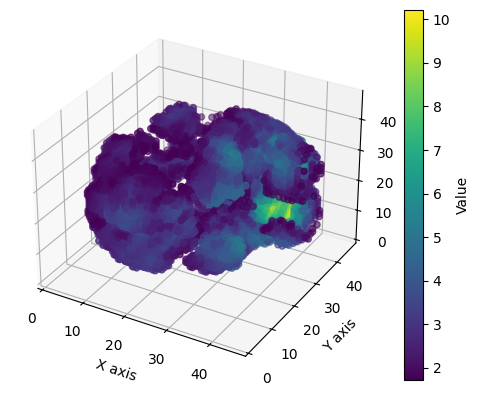

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D array (example)
data = X_train[100]
dim_x = data.shape[0]
dim_y = data.shape[1]
dim_z = data.shape[2]

# Prepare the grid
x, y, z = np.meshgrid(np.arange(dim_x), np.arange(dim_y), np.arange(dim_z), indexing='ij')

# Flatten the arrays for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
values = data.flatten()

# Set a threshold to filter out low values
threshold = np.percentile(values, 90)  # Keep only the top 10% of values
mask = values > threshold  # Only plot values above the threshold

# Create a 3D scatter plot for points above the threshold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=values[mask], cmap='viridis')

# Add labels and color bar
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
fig.colorbar(sc, ax=ax, label="Value")

plt.show()


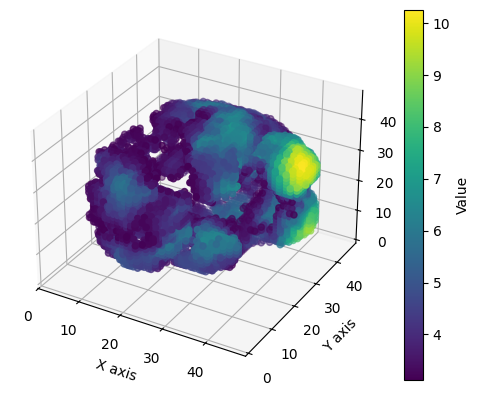

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D array (example)
data = X_train[1]
dim_x = data.shape[0]
dim_y = data.shape[1]
dim_z = data.shape[2]

# Prepare the grid
x, y, z = np.meshgrid(np.arange(dim_x), np.arange(dim_y), np.arange(dim_z), indexing='ij')

# Flatten the arrays for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
values = data.flatten()

# Set a threshold to filter out low values
threshold = np.percentile(values, 90)  # Keep only the top 10% of values
mask = values > threshold  # Only plot values above the threshold

# Create a 3D scatter plot for points above the threshold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=values[mask], cmap='viridis')

# Add labels and color bar
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
fig.colorbar(sc, ax=ax, label="Value")

plt.show()


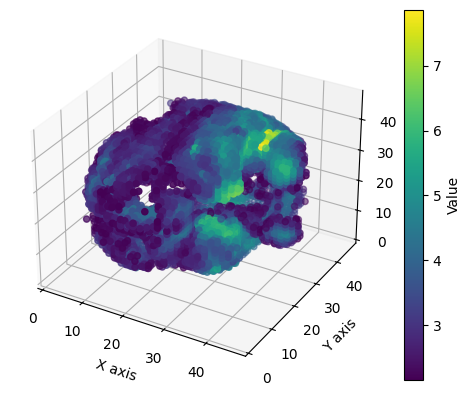

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D array (example)
data = X_train[200]
dim_x = data.shape[0]
dim_y = data.shape[1]
dim_z = data.shape[2]

# Prepare the grid
x, y, z = np.meshgrid(np.arange(dim_x), np.arange(dim_y), np.arange(dim_z), indexing='ij')

# Flatten the arrays for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
values = data.flatten()

# Set a threshold to filter out low values
threshold = np.percentile(values, 90)  # Keep only the top 10% of values
mask = values > threshold  # Only plot values above the threshold

# Create a 3D scatter plot for points above the threshold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=values[mask], cmap='viridis')

# Add labels and color bar
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
fig.colorbar(sc, ax=ax, label="Value")

plt.show()

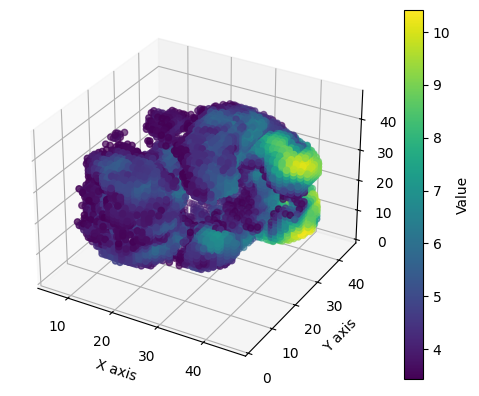

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D array (example)
data = X_train[250]
dim_x = data.shape[0]
dim_y = data.shape[1]
dim_z = data.shape[2]

# Prepare the grid
x, y, z = np.meshgrid(np.arange(dim_x), np.arange(dim_y), np.arange(dim_z), indexing='ij')

# Flatten the arrays for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
values = data.flatten()

# Set a threshold to filter out low values
threshold = np.percentile(values, 90)  # Keep only the top 10% of values
mask = values > threshold  # Only plot values above the threshold

# Create a 3D scatter plot for points above the threshold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=values[mask], cmap='viridis')

# Add labels and color bar
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
fig.colorbar(sc, ax=ax, label="Value")

plt.show()

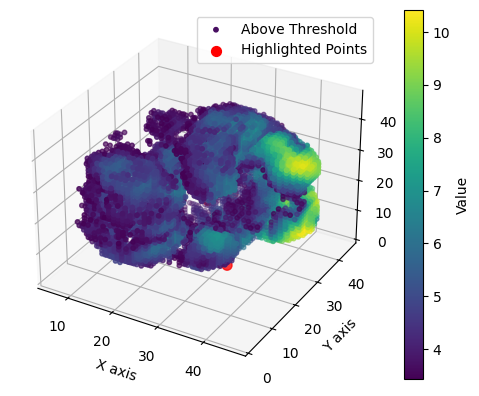

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_train is already defined and loaded with data
# Extract the data for X_train[250]
data = X_train[250]
dim_x, dim_y, dim_z = data.shape

# Prepare the grid
x, y, z = np.meshgrid(np.arange(dim_x), np.arange(dim_y), np.arange(dim_z), indexing='ij')

# Flatten the arrays for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
values = data.flatten()

# Set a threshold to filter out low values
threshold = np.percentile(values, 90)  # Keep only the top 10% of values
mask = values > threshold  # Only plot values above the threshold

# List of specific coordinates to highlight
highlight_coords = [
    (25, 10, 24),
    (35, 18, 7),
    (25, 33, 5),
    (26, 27, 18),
    (30, 30, 20),
    (30, 24, 43),
    (33, 26, 41)
]

# Convert highlight coordinates to a mask for easy plotting
highlight_mask = np.zeros_like(values, dtype=bool)
for coord in highlight_coords:
    index = coord[0] * dim_y * dim_z + coord[1] * dim_z + coord[2]  # Calculate flattened index
    highlight_mask[index] = True

# Create a 3D scatter plot for points above the threshold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all points above the threshold
sc = ax.scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=values[mask], cmap='viridis', s=10, label='Above Threshold')

# Plot highlighted points with a different color and size
ax.scatter(x_flat[highlight_mask], y_flat[highlight_mask], z_flat[highlight_mask], c='red', s=50, label='Highlighted Points')

# Add labels, color bar, and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
fig.colorbar(sc, ax=ax, label="Value")
ax.legend()

plt.show()


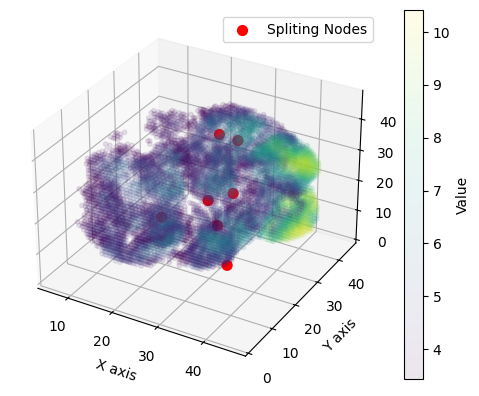

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_train is already defined and loaded with data
# Extract the data for X_train[250]
data = X_train[250]
dim_x, dim_y, dim_z = data.shape

# Prepare the grid
x, y, z = np.meshgrid(np.arange(dim_x), np.arange(dim_y), np.arange(dim_z), indexing='ij')

# Flatten the arrays for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
values = data.flatten()

# Set a threshold to filter out low values
threshold = np.percentile(values, 90)  # Keep only the top 10% of values
mask = values > threshold  # Only plot values above the threshold

# List of specific coordinates to highlight
highlight_coords = [
    (25, 10, 24),
    (35, 18, 7),
    (25, 33, 5),
    (26, 27, 18),
    (30, 30, 20),
    (30, 24, 43),
    (33, 26, 41)
]

# Convert highlight coordinates to a mask for easy plotting
highlight_mask = np.zeros_like(values, dtype=bool)
for coord in highlight_coords:
    index = coord[0] * dim_y * dim_z + coord[1] * dim_z + coord[2]  # Calculate flattened index
    highlight_mask[index] = True

# Create a 3D scatter plot for points above the threshold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all points above the threshold with transparency
sc = ax.scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=values[mask], cmap='viridis', s=10, alpha=0.1)

# Plot highlighted points with no transparency and larger size
ax.scatter(x_flat[highlight_mask], y_flat[highlight_mask], z_flat[highlight_mask], c='red', s=50, label='Spliting Nodes', alpha=1.0)

# Add labels, color bar, and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
fig.colorbar(sc, ax=ax, label="Value")
ax.legend()

plt.show()
